In [7]:
import os
import json
import pickle
from bisect import bisect_left, bisect_right
from datetime import datetime, timedelta
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import preprocessing
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [2]:
DATADIR = "/Users/natasha/Desktop/lenta_hack/"
trans_file = DATADIR + "transactions.parquet"
clients_file = DATADIR + "clients.csv"
materials_file = DATADIR + "materials.csv"
plants_file = DATADIR + "plants.csv"

In [ ]:
%%time
trans = pd.read_parquet(trans_file, engine='pyarrow', use_threads=True)

In [ ]:
trans.head()

In [ ]:
clients = pd.read_csv(clients_file)

In [ ]:
clients.head()

In [ ]:
materials = pd.read_csv(materials_file)

In [ ]:
materials.head()

In [ ]:
plants = pd.read_csv(plants_file)

In [ ]:
plants.head()

In [ ]:
trans_mat = pd.merge(trans, materials, on='material')

In [ ]:
del trans

In [ ]:
trans_mat.head()

In [ ]:
trans_mat_plant = trans_mat.merge(plants, on='plant')

In [ ]:
le = preprocessing.LabelEncoder()

trans_mat_plant['chq_id'] = le.fit_transform(trans_mat_plant['chq_id'])
trans_mat_plant['plant'] = le.fit_transform(trans_mat_plant['plant'])
trans_mat_plant['material'] = le.fit_transform(trans_mat_plant['material'])
trans_mat_plant['hier_level_1'] = le.fit_transform(trans_mat_plant['hier_level_1'])
trans_mat_plant['hier_level_2'] = le.fit_transform(trans_mat_plant['hier_level_2'])
trans_mat_plant['hier_level_3'] = le.fit_transform(trans_mat_plant['hier_level_3'])
trans_mat_plant['hier_level_4'] = le.fit_transform(trans_mat_plant['hier_level_4'])
trans_mat_plant['vendor'] = le.fit_transform(trans_mat_plant['vendor'])
trans_mat_plant['plant_type'] = le.fit_transform(trans_mat_plant['plant_type'])

In [ ]:
le = preprocessing.LabelEncoder()

clients['city'] = le.fit_transform(clients['city'])

clients["birthyear"] = 2017 - clients["birthyear"]
clients["age"] = clients["birthyear"]
clients = clients.drop(columns=["birthyear"])

In [ ]:
trans_mat_plant.head()

In [ ]:
clients = clients.dropna()

In [ ]:
clients['gender'] = le.fit_transform(clients['gender'])

In [ ]:
clients.head()

In [ ]:
trans_mat_plant_client_1 = trans_mat_plant[["client_id", "is_promo", "hier_level_1", "plant_type", "is_private_label", "is_alco"]].groupby(by=["client_id"]).mean()

In [ ]:
trans_mat_plant_client_2 = trans_mat_plant[["client_id", "sales_count", "sales_sum"]].groupby(by=["client_id"]).sum()

In [ ]:
clients = clients.merge(trans_mat_plant_client_1, on='client_id')

In [ ]:
clients = clients.merge(trans_mat_plant_client_2, on='client_id')

In [ ]:
clients.head()

In [ ]:
plant_pop = trans_mat_plant.groupby('client_id').plant.agg(lambda x:x.value_counts().index[0])

In [ ]:
clients = clients.merge(plant_pop, on='client_id')

In [ ]:
clients.head()

In [3]:
clients.to_csv(DATADIR + "clients_preprocessed.csv")

NameError: name 'clients' is not defined

In [14]:
clients = pd.read_csv(DATADIR + "clients_preprocessed.csv")

In [15]:
le = preprocessing.LabelEncoder()
clients['client_id'] = le.fit_transform(clients['client_id'])
clients['promo_ratio'] = clients['is_promo']
clients['store_type_ratio'] = clients['plant_type']
clients['prior_store'] = clients['plant'] 
clients['private_label_ratio'] = clients['is_private_label']
clients['alco_ratio'] = clients['is_alco']
clients['food_nonfood_ratio'] = clients['hier_level_1']
clients = clients.drop(columns=[
    "Unnamed: 0", "client_id", "is_promo", "plant_type", "plant", "is_private_label", "is_alco", "hier_level_1"])

In [16]:
clients = clients.iloc[:30000]

In [17]:
from sklearn import preprocessing

x = clients.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
clients_normed = pd.DataFrame(x_scaled)

In [10]:
dbscan = cluster.DBSCAN(eps=.3, min_samples=5, algorithm='ball_tree').fit(clients)

In [11]:
np.unique(dbscan.labels_)

array([-1])

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(clients_normed)

print(pca.explained_variance_ratio_)

[0.46692632 0.16401525]


In [25]:
clients_2pca = pca.fit_transform(clients)

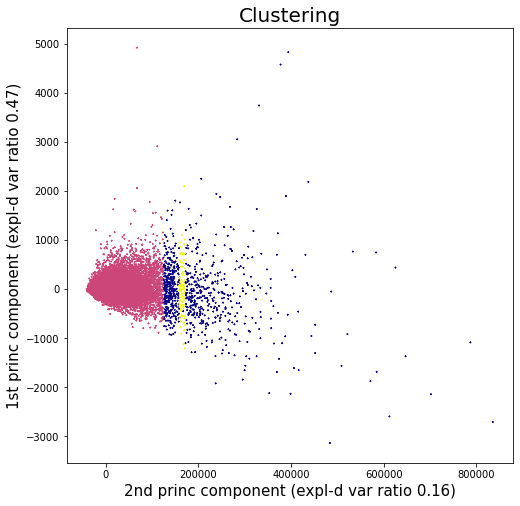

In [29]:
plt.figure(figsize=(8, 8))
plt.scatter(clients_2pca[:, 0], clients_2pca[:, 1], marker='x', s=1, c=optics.labels_, cmap='plasma')
plt.ylabel(f'1st princ component (expl-d var ratio {pca.explained_variance_ratio_[0]:.2f})', fontsize=15)
plt.xlabel(f'2nd princ component (expl-d var ratio {pca.explained_variance_ratio_[1]:.2f})', fontsize=15)
plt.title('Clustering', fontsize=20)
# plt.legend(['1st cluster', '2nd cluster'])
# plt.savefig('./clustering.pdf')
plt.show()

In [21]:
optics = cluster.OPTICS(min_samples=100)

In [22]:
optics.fit(clients)

OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=None, min_samples=100, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.05)

In [23]:
np.unique(optics.labels_)

array([-1,  0,  1])

In [13]:
affinity_propagation = cluster.AffinityPropagation(damping=.9, preference=-200)

In [ ]:
affinity_propagation.fit(clients)

In [ ]:
affinity_propagation.labels_

In [16]:
ms = cluster.MeanShift()

In [30]:
clients.loc[:, 'num_cluster'] = optics.labels_[:]

In [113]:
clients_0 = clients[clients['num_cluster'] == 0]
clients_1 = clients[clients['num_cluster'] == 1]

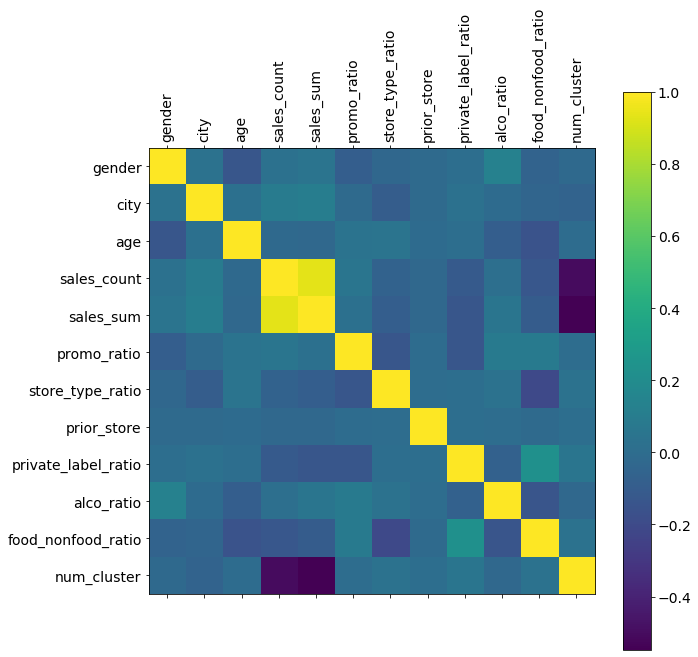

In [31]:
f = plt.figure(figsize=(10, 10))
plt.matshow(clients.corr(), fignum=f.number)
plt.xticks(range(clients.shape[1]), clients.columns, fontsize=14, rotation=90)
plt.yticks(range(clients.shape[1]), clients.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
# plt.savefig('./corr_map.pdf')

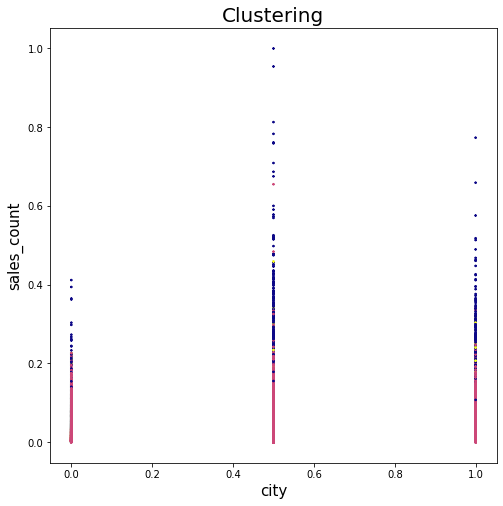

In [45]:
plt.figure(figsize=(8, 8))
plt.scatter(clients_normed.loc[:, 1], clients_normed.loc[:, 3], marker='x', s=3, c=optics.labels_, cmap='plasma')
plt.xlabel(f'city', fontsize=15)
plt.ylabel(f'sales_count', fontsize=15)
plt.title('Clustering', fontsize=20)
# plt.legend(['1st cluster', '2nd cluster'])
# plt.savefig('./clustering.pdf')
plt.show()

In [123]:
clients_normed.loc[:, 0]

0        1.0
1        0.0
2        1.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       1.0
12       0.0
13       0.0
14       1.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       1.0
23       0.0
24       1.0
25       0.0
26       1.0
27       1.0
28       1.0
29       0.0
        ... 
98061    1.0
98062    0.0
98063    1.0
98064    1.0
98065    0.0
98066    0.0
98067    0.0
98068    1.0
98069    1.0
98070    0.0
98071    0.0
98072    1.0
98073    0.0
98074    0.0
98075    0.0
98076    0.0
98077    0.0
98078    0.0
98079    0.0
98080    1.0
98081    1.0
98082    0.0
98083    0.0
98084    1.0
98085    1.0
98086    1.0
98087    0.0
98088    1.0
98089    0.0
98090    0.0
Name: 0, Length: 98091, dtype: float64

In [121]:
clients_normed

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.5,0.395973,0.053853,0.012291,0.304910,0.000000,0.583979,0.201550,0.105943,0.147287,0.166667
1,0.0,0.5,0.536913,0.015331,0.005738,0.574163,0.000000,0.170543,0.392344,0.009569,0.464115,0.333333
2,1.0,0.5,0.489933,0.004789,0.002045,0.412698,0.000000,0.614987,0.269841,0.015873,0.206349,0.166667
3,0.0,0.0,0.557047,0.003387,0.001516,0.264151,1.000000,0.589147,0.113208,0.000000,0.169811,0.500000
4,0.0,0.5,0.409396,0.036263,0.014375,0.812500,0.000000,0.558140,0.210069,0.029514,0.250000,0.333333
5,0.0,0.0,0.416107,0.006035,0.003874,0.530120,0.000000,0.067183,0.144578,0.000000,0.518072,0.500000
6,0.0,0.5,0.348993,0.001285,0.000975,0.380952,0.000000,0.630491,0.190476,0.000000,0.285714,0.333333
7,0.0,0.5,0.677852,0.003849,0.002016,0.796875,0.406250,0.229974,0.031250,0.000000,0.171875,0.333333
8,0.0,0.5,0.436242,0.082437,0.016295,0.457612,1.000000,0.821705,0.383774,0.013674,0.197812,0.333333
9,0.0,0.5,0.651007,0.007266,0.003172,0.358779,0.000000,0.322997,0.145038,0.099237,0.114504,0.333333


In [89]:
clients[clients['num_cluster'] == 1][:20]

,gender,city,age,sales_count,sales_sum,promo_ratio,store_type_ratio,prior_store,private_label_ratio,alco_ratio,food_nonfood_ratio,num_cluster
0,1,1,27.0,940.828,52602.00,0.304910,0.000000,226,0.201550,0.105943,0.147287,1
2,1,1,41.0,83.663,6596.00,0.412698,0.000000,238,0.269841,0.015873,0.206349,1
11,1,1,45.0,66.936,5689.00,0.442623,0.000000,361,0.114754,0.016393,0.163934,1
14,1,0,24.0,504.799,34431.00,0.544898,0.000000,322,0.228571,0.024490,0.108163,1
22,1,1,47.0,423.065,46762.00,0.169725,0.000000,324,0.325688,0.004587,0.348624,1
24,1,2,60.0,589.114,66996.00,0.593023,0.000000,179,0.209302,0.083721,0.172093,1
26,1,1,60.0,624.481,55132.02,0.700000,0.000000,2,0.211538,0.000000,0.142308,1
27,1,1,27.0,71.125,6059.00,0.542373,0.000000,205,0.101695,0.000000,0.355932,1
28,1,1,41.0,272.868,26616.00,0.511211,0.000000,41,0.219731,0.017937,0.170404,1
30,1,1,31.0,189.326,10218.00,0.506329,0.000000,308,0.151899,0.000000,0.265823,1


In [31]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
gender              40000 non-null int64
city                40000 non-null int64
age                 40000 non-null float64
is_promo            40000 non-null float64
hier_level_1        40000 non-null float64
plant_type          40000 non-null float64
is_private_label    40000 non-null float64
is_alco             40000 non-null float64
sales_count         40000 non-null float64
sales_sum           40000 non-null float64
plant               40000 non-null int64
dtypes: float64(8), int64(3)
memory usage: 3.4 MB


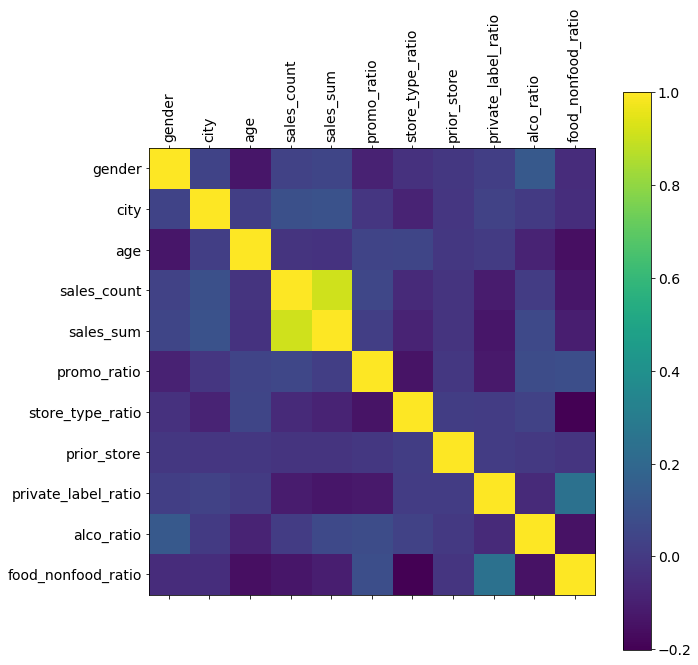

In [62]:
f = plt.figure(figsize=(10, 10))
plt.matshow(clients.corr(), fignum=f.number)
plt.xticks(range(clients.shape[1]), clients.columns, fontsize=14, rotation=90)
plt.yticks(range(clients.shape[1]), clients.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.savefig('./corr_map.pdf')
# plt.title('Correlation Matrix', fontsize=16)

In [33]:
clients

,gender,city,age,is_promo,hier_level_1,plant_type,is_private_label,is_alco,sales_count,sales_sum,plant
0,1,1,27.0,0.304910,0.147287,0.000000,0.201550,0.105943,940.828,52602.00,226
1,0,1,48.0,0.574163,0.464115,0.000000,0.392344,0.009569,267.843,23178.00,66
2,1,1,41.0,0.412698,0.206349,0.000000,0.269841,0.015873,83.663,6596.00,238
3,0,0,51.0,0.264151,0.169811,1.000000,0.113208,0.000000,59.176,4223.00,228
4,0,1,29.0,0.812500,0.250000,0.000000,0.210069,0.029514,633.537,61957.00,216
5,0,0,30.0,0.530120,0.518072,0.000000,0.144578,0.000000,105.426,14810.00,26
6,0,1,20.0,0.380952,0.285714,0.000000,0.190476,0.000000,22.442,1793.00,244
7,0,1,69.0,0.796875,0.171875,0.406250,0.031250,0.000000,67.244,6466.00,89
8,0,1,33.0,0.457612,0.197812,1.000000,0.383774,0.013674,1440.217,70578.01,318
9,0,1,65.0,0.358779,0.114504,0.000000,0.145038,0.099237,126.946,11659.00,125
